### Feature Engineering Summary

- **Time-based features:** Added `Hour`, `Day`, dropped raw `Time`.  
- **Amount-based features:** Added log-transformed and scaled versions.  
- **Class imbalance:** Confirmed extreme imbalance (~0.17% fraud).  
- **Statistical insights:** Fraudulent transactions tend to have smaller medians, but some large outliers exist.  
- **PCA:** Reduced high-dimensional V-features into 2 components (`PCA1`, `PCA2`) for visualization & potential model input.  
- ✅ Saved fully processed dataset at `data/processed/creditcard_processed.csv`.  

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [4]:
df = pd.read_csv("../data/raw/creditcard.csv")
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Extract Hour (time of day)
df["Hour"] = (df["Time"] // 3600) % 24

# Day (every 24h)
df["Day"] = (df["Time"] // (3600*24))

# Drop raw Time column
df = df.drop(columns=["Time"])

In [6]:
# Log transform
df["Amount_log"] = np.log1p(df["Amount"])

# Scale Amount & Amount_log (keep both for flexibility)
scaler = StandardScaler()
df[["Amount_scaled", "Amount_log_scaled"]] = scaler.fit_transform(df[["Amount", "Amount_log"]])

/tmp/ipykernel_8627/2423256977.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Class", data=df, palette=["skyblue", "red"])


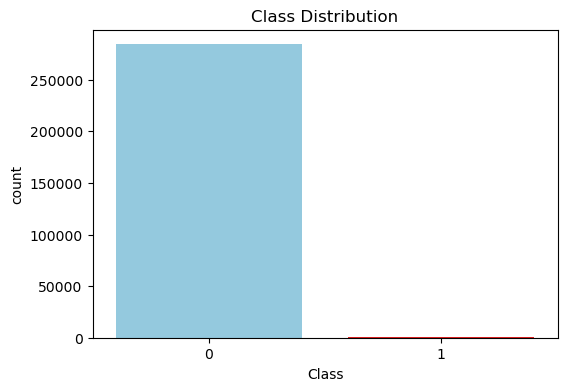

Fraudulent transactions: 0.173% of total


In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x="Class", data=df, palette=["skyblue", "red"])
plt.title("Class Distribution")
plt.show()

fraud_pct = (df["Class"].mean() * 100).round(3)
print(f"Fraudulent transactions: {fraud_pct}% of total")

In [8]:
print("Transaction Amount Summary:\n", df.groupby("Class")["Amount"].describe())
print("\nTransaction per Hour:\n", df.groupby("Hour")["Class"].mean().sort_values(ascending=False).head())

Transaction Amount Summary:
           count        mean         std  min   25%    50%     75%       max
Class                                                                      
0      284315.0   88.291022  250.105092  0.0  5.65  22.00   77.05  25691.16
1         492.0  122.211321  256.683288  0.0  1.00   9.25  105.89   2125.87

Transaction per Hour:
 Hour
2.0    0.017127
4.0    0.010412
3.0    0.004868
5.0    0.003679
7.0    0.003175
Name: Class, dtype: float64


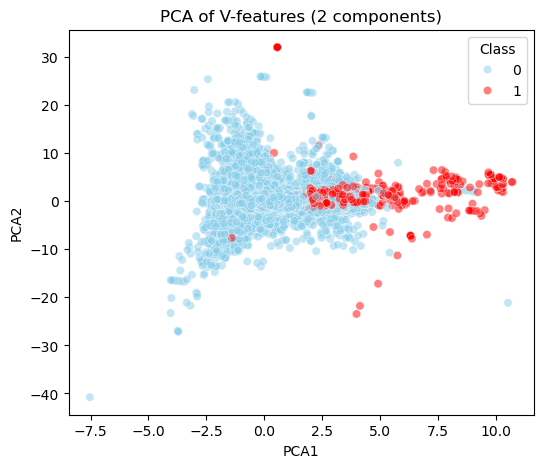

In [14]:
v_features = [col for col in df.columns if col.startswith("V")]

# Scale V-features before PCA
scaler_v = StandardScaler()
v_scaled = scaler_v.fit_transform(df[v_features])

# Apply PCA
pca = PCA(n_components=2, random_state=42)
df_pca = pca.fit_transform(v_scaled)

# Add back to dataframe
df["PCA1"] = df_pca[:, 0]
df["PCA2"] = df_pca[:, 1]

# Quick scatter plot
plt.figure(figsize=(6,5))
sns.scatterplot(x="PCA1", y="PCA2", hue="Class", data=df, alpha=0.5, palette={0:"skyblue",1:"red"})
plt.title("PCA of V-features (2 components)")
plt.show()


In [10]:
df.to_csv("../data/processed/creditcard_processed.csv", index=False)
print("✅ Processed dataset saved to data/processed/creditcard_processed.csv")

✅ Processed dataset saved to data/processed/creditcard_processed.csv
